# Model REST API

The Model REST API provides an interface for transforming models in various ways. Here are some examples. The model REST API documentation is available at [http://mira-epi-dkg-lb-c7b58edea41524e6.elb.us-east-1.amazonaws.com:8771/docs#/](http://mira-epi-dkg-lb-c7b58edea41524e6.elb.us-east-1.amazonaws.com:8771/docs#/)

## Setup

We will need `requests` to send requests to the model api.

In [1]:
import requests
from mira.metamodel import Concept, ControlledConversion, NaturalConversion, TemplateModel

# rest_url = "http://127.0.0.1:8000"  # Local service
rest_url = "http://mira-epi-dkg-lb-c7b58edea41524e6.elb.us-east-1.amazonaws.com:8771"

# Example TemplateModel
infected = Concept(name="infected population", identifiers={"ido": "0000511"})
susceptible = Concept(name="susceptible population", identifiers={"ido": "0000514"})
immune = Concept(name="immune population", identifiers={"ido": "0000592"})
controlled_conversion = ControlledConversion(
    controller=infected,
    subject=susceptible,
    outcome=infected,
)
natural_conversion = NaturalConversion(subject=infected, outcome=immune)
sir_template_model = TemplateModel(templates=[controlled_conversion, natural_conversion])
sir_template_model_dict = sir_template_model.m()
print(sir_template_model.model_dump_json())

{"templates": [{"rate_law": null, "type": "ControlledConversion", "controller": {"name": "infected population", "identifiers": {"ido": "0000511"}, "context": {}}, "subject": {"name": "susceptible population", "identifiers": {"ido": "0000514"}, "context": {}}, "outcome": {"name": "infected population", "identifiers": {"ido": "0000511"}, "context": {}}, "provenance": []}, {"rate_law": null, "type": "NaturalConversion", "subject": {"name": "infected population", "identifiers": {"ido": "0000511"}, "context": {}}, "outcome": {"name": "immune population", "identifiers": {"ido": "0000592"}, "context": {}}, "provenance": []}], "parameters": {}, "initials": {}}


## PetriNet

The `/api/to_petrinet` endpoint returns a PetriNet model based on the `TemplateModel` provided:

In [2]:
res = requests.post(rest_url + "/api/to_petrinet", json=sir_template_model_dict)
print(res.json())

{'S': [{'sname': 'susceptible population', 'mira_ids': "[('identity', 'ido:0000514')]", 'mira_context': '[]'}, {'sname': 'infected population', 'mira_ids': "[('identity', 'ido:0000511')]", 'mira_context': '[]'}, {'sname': 'immune population', 'mira_ids': "[('identity', 'ido:0000592')]", 'mira_context': '[]'}], 'T': [{'tname': 't1', 'template_type': 'ControlledConversion', 'parameter_name': "(('susceptible population', ('identity', 'ido:0000514')), ('infected population', ('identity', 'ido:0000511')), ('infected population', ('identity', 'ido:0000511')), 'ControlledConversion', 'rate')", 'parameter_value': None}, {'tname': 't2', 'template_type': 'NaturalConversion', 'parameter_name': "(('infected population', ('identity', 'ido:0000511')), ('immune population', ('identity', 'ido:0000592')), 'NaturalConversion', 'rate')", 'parameter_value': None}], 'I': [{'is': 2, 'it': 1}, {'is': 1, 'it': 1}, {'is': 2, 'it': 2}], 'O': [{'os': 2, 'ot': 1}, {'os': 2, 'ot': 1}, {'os': 3, 'ot': 2}]}


## Model Stratification

The `/api/stratify` endpoint can stratify a model. In this example, the stratification is along two cities, effectively creating a two-city SIR model from the original SIR model:

In [3]:
res = requests.post(rest_url + "/api/stratify", json={"template_model": sir_template_model_dict, "key": "city", "strata": ["Boston", "New York City"]})
print(res.json())

{'templates': [{'rate_law': None, 'type': 'ControlledConversion', 'controller': {'name': 'infected population', 'identifiers': {'ido': '0000511'}, 'context': {'city': 'Boston'}}, 'subject': {'name': 'susceptible population', 'identifiers': {'ido': '0000514'}, 'context': {'city': 'Boston'}}, 'outcome': {'name': 'infected population', 'identifiers': {'ido': '0000511'}, 'context': {'city': 'Boston'}}, 'provenance': []}, {'rate_law': None, 'type': 'NaturalConversion', 'subject': {'name': 'infected population', 'identifiers': {'ido': '0000511'}, 'context': {'city': 'Boston'}}, 'outcome': {'name': 'immune population', 'identifiers': {'ido': '0000592'}, 'context': {'city': 'Boston'}}, 'provenance': []}, {'rate_law': None, 'type': 'ControlledConversion', 'controller': {'name': 'infected population', 'identifiers': {'ido': '0000511'}, 'context': {'city': 'New York City'}}, 'subject': {'name': 'susceptible population', 'identifiers': {'ido': '0000514'}, 'context': {'city': 'New York City'}}, 'ou

## Biomodels Model
The `/api/biomodels/<model id>` endpoint returns a `TemplateModel` json of the biomodels model.

In [4]:
res = requests.get(rest_url + "/api/biomodels/BIOMD0000000956")
print(res.json())

{'templates': [{'rate_law': '1.0*Infected*Susceptible*(ModelValue_2*ModelValue_5 + ModelValue_6*ModelValue_9)*(ModelValue_5*Ro_CA + ModelValue_6*Ro_NY)', 'type': 'ControlledConversion', 'controller': {'name': 'Infected', 'identifiers': {'ncit': 'C171133', 'ido': '0000511', 'biomodels.species': 'BIOMD0000000956:Infected'}, 'context': {}}, 'subject': {'name': 'Susceptible', 'identifiers': {'ido': '0000514', 'ncit': 'C171133', 'biomodels.species': 'BIOMD0000000956:Susceptible'}, 'context': {}}, 'outcome': {'name': 'Infected', 'identifiers': {'ncit': 'C171133', 'ido': '0000511', 'biomodels.species': 'BIOMD0000000956:Infected'}, 'context': {}}, 'provenance': []}, {'rate_law': '1.0*Infected*(ModelValue_2*ModelValue_5 + ModelValue_6*ModelValue_9)', 'type': 'NaturalConversion', 'subject': {'name': 'Infected', 'identifiers': {'ncit': 'C171133', 'ido': '0000511', 'biomodels.species': 'BIOMD0000000956:Infected'}, 'context': {}}, 'outcome': {'name': 'Recovered', 'identifiers': {'ncit': 'C171133', 

## Bilayer Endpoints
The `/api/model_to_bilayer` and `/api/bilayer_to_model` endpoints can translate between a `TemplateModel` json and a `Bilayer`

In [5]:
# Get a bilayer json representation from a TemplateModel json
res = requests.post(rest_url + "/api/model_to_bilayer", json=sir_template_model_dict)
print(res.json())

{'Wa': [{'influx': 1, 'infusion': 2}, {'influx': 2, 'infusion': 3}], 'Win': [{'arg': 2, 'call': 1}, {'arg': 1, 'call': 1}, {'arg': 2, 'call': 2}], 'Box': [{'parameter': "(('susceptible population', ('identity', 'ido:0000514')), ('infected population', ('identity', 'ido:0000511')), ('infected population', ('identity', 'ido:0000511')), 'ControlledConversion', 'rate')"}, {'parameter': "(('infected population', ('identity', 'ido:0000511')), ('immune population', ('identity', 'ido:0000592')), 'NaturalConversion', 'rate')"}], 'Qin': [{'variable': "('susceptible population', ('identity', 'ido:0000514'))"}, {'variable': "('infected population', ('identity', 'ido:0000511'))"}, {'variable': "('immune population', ('identity', 'ido:0000592'))"}], 'Qout': [{'tanvar': "('susceptible population', ('identity', 'ido:0000514'), 'derivative')"}, {'tanvar': "('infected population', ('identity', 'ido:0000511'), 'derivative')"}, {'tanvar': "('immune population', ('identity', 'ido:0000592'), 'derivative')"}

In [6]:
# Reverse the process by providing the bilayer json and get back the SIR TemplateModel json
bilayer_json = res.json()
res = requests.post(rest_url + "/api/bilayer_to_model", json=bilayer_json)
print(res.json())

{'templates': [{'rate_law': "('infected population', ('identity', 'ido:0000511'))*('susceptible population', ('identity', 'ido:0000514'))*(('susceptible population', ('identity', 'ido:0000514')), ('infected population', ('identity', 'ido:0000511')), ('infected population', ('identity', 'ido:0000511')), 'ControlledConversion', 'rate')", 'type': 'ControlledConversion', 'controller': {'name': "('infected population', ('identity', 'ido:0000511'))", 'identifiers': {}, 'context': {}}, 'subject': {'name': "('susceptible population', ('identity', 'ido:0000514'))", 'identifiers': {}, 'context': {}}, 'outcome': {'name': "('infected population', ('identity', 'ido:0000511'))", 'identifiers': {}, 'context': {}}, 'provenance': []}, {'rate_law': "('infected population', ('identity', 'ido:0000511'))*(('infected population', ('identity', 'ido:0000511')), ('immune population', ('identity', 'ido:0000592')), 'NaturalConversion', 'rate')", 'type': 'NaturalConversion', 'subject': {'name': "('infected popula

## SBML XML To Model
For the `/api/sbml_xml_to_model` endpoint, you can provide an SBML model in the form of a string of the XML and get back a model.

First, get an XML string. Here, done by the `get_sbml_model` function from the `biomodels` submodule in MIRA:

In [7]:
from mira.sources.biomodels import get_sbml_model
biomd951_xml_str = get_sbml_model("BIOMD0000000956")
print(biomd951_xml_str[:250])

<?xml version='1.0' encoding='UTF-8' standalone='no'?>
<sbml xmlns="http://www.sbml.org/sbml/level2/version4" level="2" version="4">
  <model id="Bertozzi2020___SIR_model_of_scenarios_of_COVID_19_spread_in_CA" metaid="COPASI0" name="Bertozzi2020 - SI


Next, submit this string to the endpoint and get the corresponding model back:

In [8]:
res = requests.post(rest_url + "/api/sbml_xml_to_model", json={"xml_string": biomd951_xml_str})
print(res.json())

{'templates': [{'rate_law': '1.0*Infected*Susceptible*(ModelValue_2*ModelValue_5 + ModelValue_6*ModelValue_9)*(ModelValue_5*Ro_CA + ModelValue_6*Ro_NY)', 'type': 'ControlledConversion', 'controller': {'name': 'Infected', 'identifiers': {'ncit': 'C171133', 'ido': '0000511'}, 'context': {}}, 'subject': {'name': 'Susceptible', 'identifiers': {'ido': '0000514', 'ncit': 'C171133'}, 'context': {}}, 'outcome': {'name': 'Infected', 'identifiers': {'ncit': 'C171133', 'ido': '0000511'}, 'context': {}}, 'provenance': []}, {'rate_law': '1.0*Infected*(ModelValue_2*ModelValue_5 + ModelValue_6*ModelValue_9)', 'type': 'NaturalConversion', 'subject': {'name': 'Infected', 'identifiers': {'ncit': 'C171133', 'ido': '0000511'}, 'context': {}}, 'outcome': {'name': 'Recovered', 'identifiers': {'ncit': 'C171133'}, 'context': {'property': 'ido:0000621'}}, 'provenance': []}], 'parameters': {'Pop_CA': {'name': 'Pop_CA', 'identifiers': {}, 'context': {}, 'value': 39560000.0}, 'Ro_CA': {'name': 'Ro_CA', 'identifie

## Graphviz dot File

The `/api/viz/to_dot_file` endpoint takes a `TemplateModel` and returns a graphviz dotfile of the provided model:

In [9]:
res = requests.post(rest_url + "/api/viz/to_dot_file", json=sir_template_model_dict)
print(res.text)

strict digraph "" {
	graph [bb="0,0,178,313"];
	node [label="\N"];
	"('susceptible population', ('identity', 'ido:0000514'))"	[height=0.65278,
		label="{susceptible population | {identity | ido:0000514}}",
		pos="89,289.5",
		rects="-1.4211e-14,289.5,178,312.5 -1.4211e-14,266.5,72,289.5 72,266.5,178,289.5",
		shape=record,
		width=2.4722];
	T0	[color=blue,
		fillcolor=blue,
		fixedsize=true,
		height=0.19444,
		label="",
		pos="89,223",
		shape=square,
		style=filled,
		width=0.19444];
	"('susceptible population', ('identity', 'ido:0000514'))" -> T0	[pos="e,89,230.05 89,266.3 89,257.68 89,248 89,240.08"];
	"('infected population', ('identity', 'ido:0000511'))"	[height=0.65278,
		label="{infected population | {identity | ido:0000511}}",
		pos="89,156.5",
		rects="-1.4211e-14,156.5,178,179.5 -1.4211e-14,133.5,72,156.5 72,133.5,178,156.5",
		shape=record,
		width=2.4722];
	T0 -> "('infected population', ('identity', 'ido:0000511'))"	[pos="e,82.56,179.55 84.757,215.58 83.08,209.38 82.245,1

## Graph image

The `/api/viz/to_image` endpoint returns an image of the model as a graph structure.

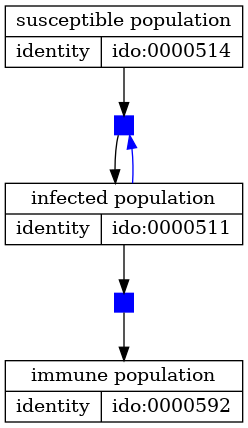

In [10]:
res = requests.post(rest_url + "/api/viz/to_image", json=sir_template_model_dict)
with open("./graph.png", "wb") as fio:
    fio.write(res.content)

from IPython.display import Image
Image(filename="./graph.png")

## Comparing Two Models
The endpoints `/api/models_to_delta_graph` and `/api/models_to_delta_image` returns a graph and a png image of the delta, respectively, of the comparison between two models.
First, let's create a modified version of the SIR model that has location specified in the context of its templates:

In [11]:
# Add a location to the templates that are not NaturalConversion (Note that this has no meaning outside as an illustration in this example)
templates_w_context = [templ.with_context(location="geonames:5128581") if not isinstance(templ, NaturalConversion) else templ for templ in sir_template_model.templates]
sir_w_context = TemplateModel(templates=templates_w_context, parameters=sir_template_model.parameters, initials=sir_template_model.initials)

Submit the two models to `/api/models_to_delta_image` to get an image of the delta graph:

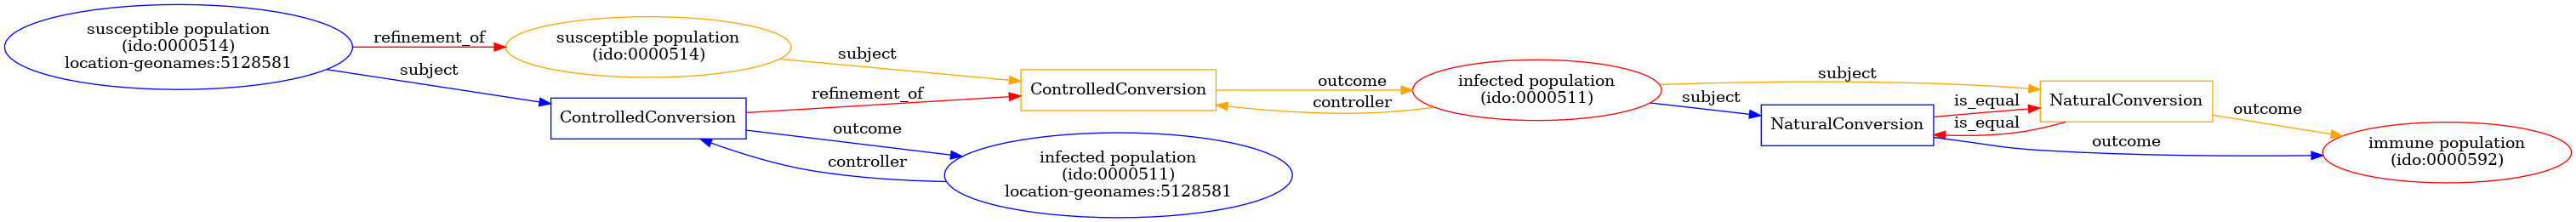

In [12]:
res = requests.post(rest_url + "/api/models_to_delta_image", json={"template_model1": sir_template_model_dict, "template_model2": sir_w_context.model_dump()})
with open("./delta_graph.png", "wb") as f:
    f.write(res.content)
Image(filename="./delta_graph.png")

From the image, it can be seen that the NaturalConversion of the two models are equals, while the ControlledConversion in one model is a refinement of the other, in this case because the context was added.

The other endpoint provides a way to download the graph seen in the image as a node-link data json:

In [13]:
res = requests.post(rest_url + "/api/models_to_delta_graph", json={"template_model1": sir_template_model_dict, "template_model2": sir_w_context.model_dump()})
print(res.json())

{'directed': True, 'multigraph': False, 'graph': {'rankdir': 'LR'}, 'nodes': [{'tags': ['1'], 'type': 'ControlledConversion', 'template_key': ['ControlledConversion', [['ido', '0000514'], []], [['ido', '0000511'], []], [['ido', '0000511'], []]], 'label': 'ControlledConversion', 'color': 'orange', 'shape': 'record', 'id': ['ControlledConversion', ['infected population', ['identity', 'ido:0000511']], ['infected population', ['identity', 'ido:0000511']], ['susceptible population', ['identity', 'ido:0000514']], '1']}, {'tags': ['1', '2'], 'label': 'infected population\n(ido:0000511)', 'color': 'red', 'concept_identity_key': [['ido', '0000511'], []], 'id': ['infected population', ['identity', 'ido:0000511']]}, {'tags': ['1'], 'label': 'susceptible population\n(ido:0000514)', 'color': 'orange', 'concept_identity_key': [['ido', '0000514'], []], 'id': ['susceptible population', ['identity', 'ido:0000514']]}, {'tags': ['1'], 'type': 'NaturalConversion', 'template_key': ['NaturalConversion', [['